Choose the time series and apply {\bf sequential LSTM} (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/). Compare and contrast between the three techniques applied.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import typing as tp
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

In [ ]:
from keras.callbacks import EarlyStopping

# PREPARAMOS LOS DATOS

In [ ]:
df = pd.read_csv("UK-2007-2023 (1).csv")
df.head()

,Unnamed: 0,2007-01-02,2007-01-03,2007-01-04,2007-01-05,2007-01-08,2007-01-09,2007-01-10,2007-01-11,2007-01-12,...,2023-09-18,2023-09-19,2023-09-20,2023-09-21,2023-09-22,2023-09-25,2023-09-26,2023-09-27,2023-09-28,2023-09-29
0,Close,6310.899902,6319.0,6287.0,6220.100098,6194.200195,6196.100098,6160.700195,6230.100098,6239.0,...,7652.899902,7660.200195,7731.700195,7678.600098,7683.899902,7624.0,7625.700195,7593.200195,7601.899902,7608.100098


In [ ]:
 datosf = df.iloc[0,1:] #vuelve los datos una serie de tiempo
 datosf.head(4230)

,0
2007-01-02,6310.899902
2007-01-03,6319.0
2007-01-04,6287.0
2007-01-05,6220.100098
2007-01-08,6194.200195
...,...
2023-09-25,7624.0
2023-09-26,7625.700195
2023-09-27,7593.200195
2023-09-28,7601.899902


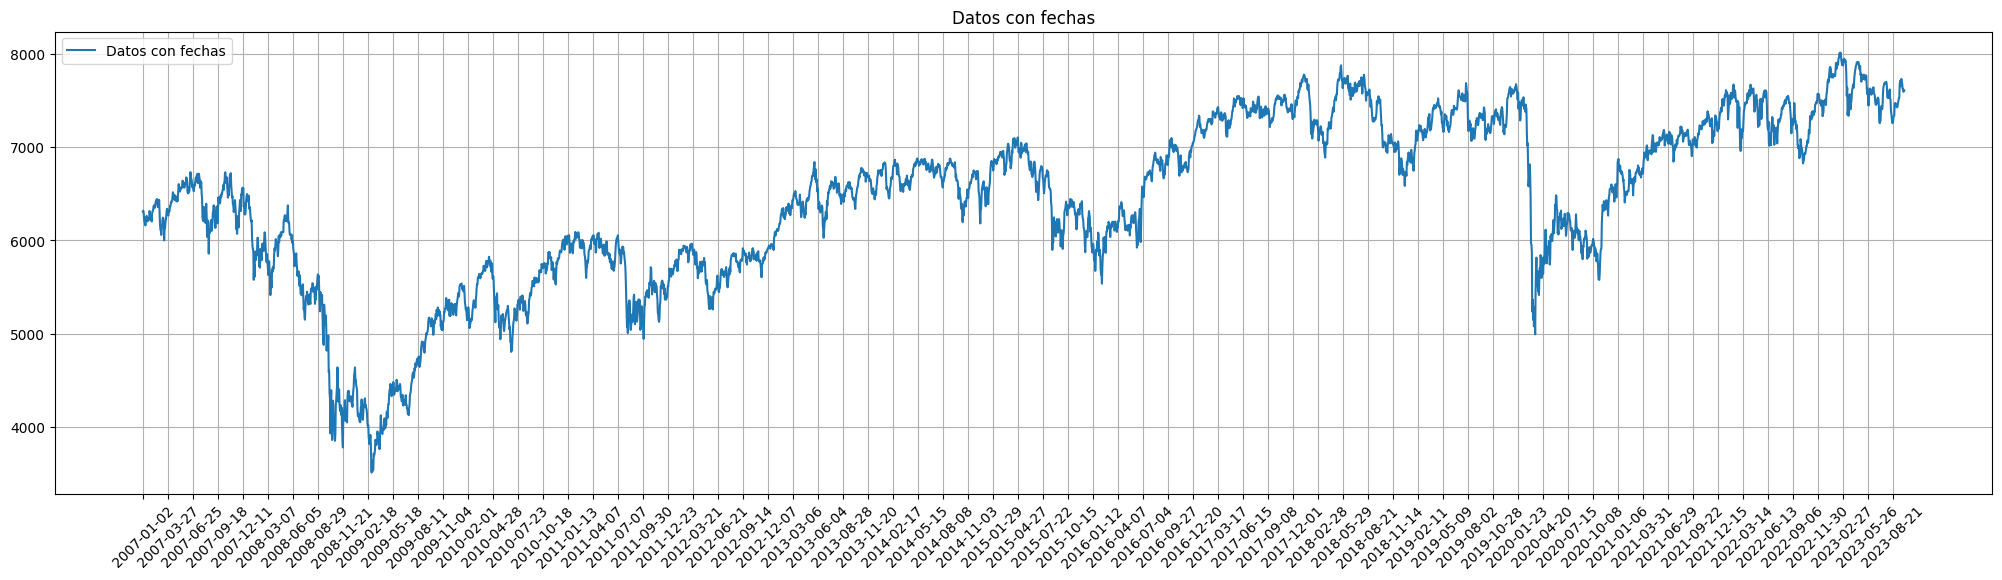

In [ ]:
plt.figure(figsize=(25, 6))
plt.title("Datos con fechas")
plt.plot(datosf, label = "Datos con fechas")
plt.xticks(datosf.index[::60], rotation=45) #ponemos la fecha cada 2 meses
plt.grid()
plt.legend()
plt.show()

In [ ]:
datos = datosf.values

Divide the time series in train and test

In [ ]:
def train_test(data: np.ndarray, p: float) -> tp.Tuple[np.ndarray, np.ndarray]:
    """
    Toma un conjunto de datos (data) y un parámetro (p)  entre 0 y 1.
    Divide los datos, tomando el 100p% de los datos para
    entrenamiento y el resto para prueba.
    Devuelve una tupla con dos arrays, (train y test).
    """
    train = data[:int(len(data)*p)] #datos desde el 0 hasta el (100p)%
    test = data[int(len(data)*p):] #resto de los datos
    return (train,test)

In [ ]:
train_data8, test_data8 = train_test(datos,0.8)  #divide los datos en entrenamiento(80%) y prueba(20%)
train_data7, test_data7 = train_test(datos, 0.7) #divide los datos en entrenamiento(70%) y prueba(30%)

In [ ]:
#Esta celda es para saber los tamaños de cada array
le8 = len(train_data8)
lt8 = len(test_data8)
le7 = len(train_data7)
lt7 = len(test_data7)

In [ ]:
#Escalamos los datos con p = 0.8
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data8 = scaler.fit_transform(train_data8.reshape(-1, 1))
scaled_test_data8 = scaler.transform(test_data8.reshape(-1, 1))

In [ ]:
#Escalamos los datos con p = 0.7
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data7 = scaler.fit_transform(train_data7.reshape(-1, 1))
scaled_test_data7 = scaler.transform(test_data7.reshape(-1, 1))

In [ ]:
#Les damos la forma que necesitamos
train_data_8 = scaled_train_data8.reshape(le8)
test_data_8 = scaled_test_data8.reshape(lt8)
train_data_7 = scaled_train_data7.reshape(le7)
test_data_7 = scaled_test_data7.reshape(lt7)

In [ ]:
serie_test_8 = pd.Series(test_data_8, index = datosf.index[len(train_data8):])
serie_test_7 = pd.Series(test_data_7, index = datosf.index[len(train_data7):])

In [ ]:
serie_train_8 = pd.Series(train_data_8, index = datosf.index[:len(train_data8)])
serie_train_7 = pd.Series(train_data_7, index = datosf.index[:len(train_data7)])

In [ ]:
indices = datosf.index

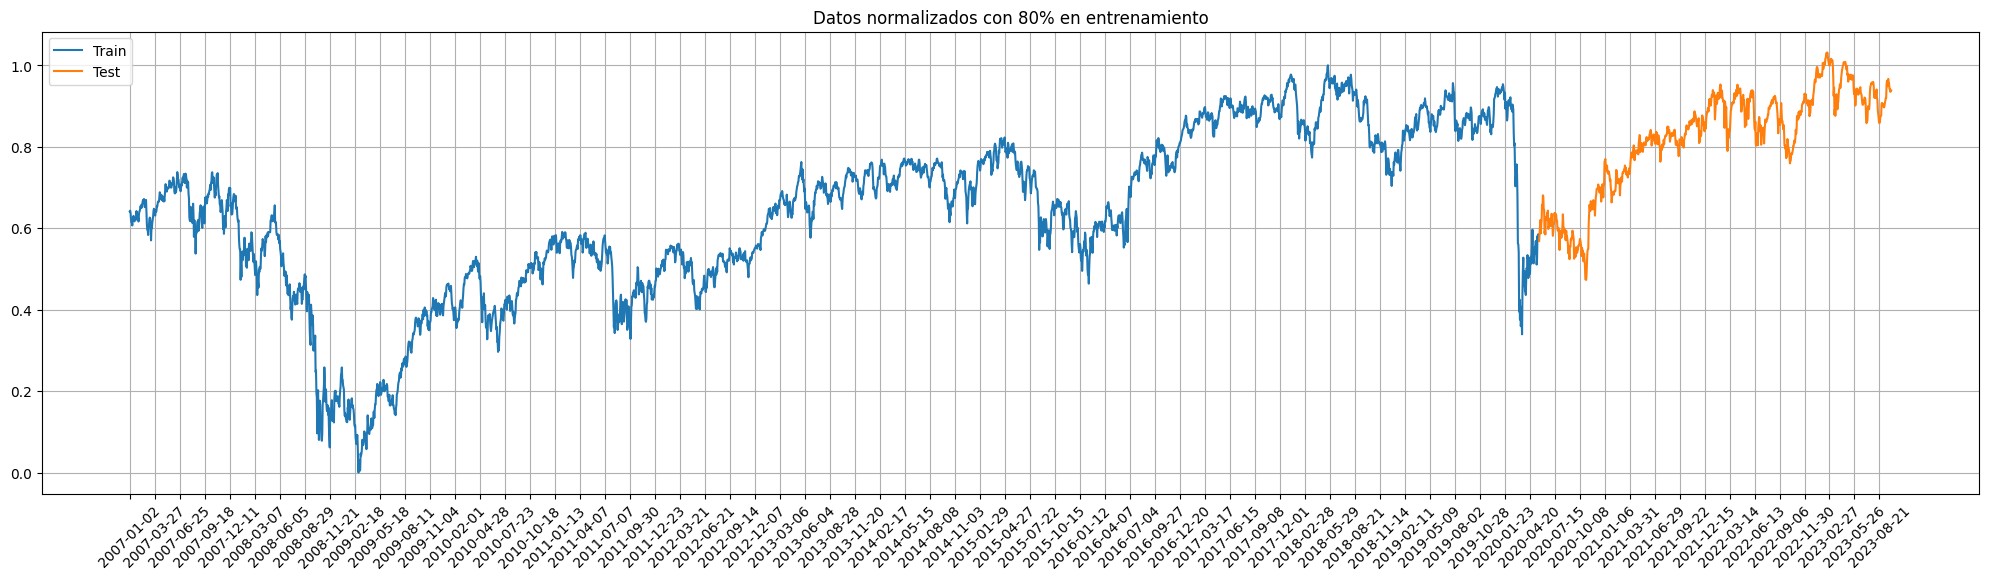

In [ ]:
plt.figure(figsize=(25,6))
plt.title("Datos normalizados con 80% en entrenamiento")
plt.plot(pd.Series(train_data_8,index = indices[0:len(train_data8)]), label = "Train")
plt.plot(pd.Series(test_data_8, index = indices[len(train_data8):]), label = "Test")
plt.xticks(datosf.index[::60], rotation=45)
plt.grid()
plt.legend()

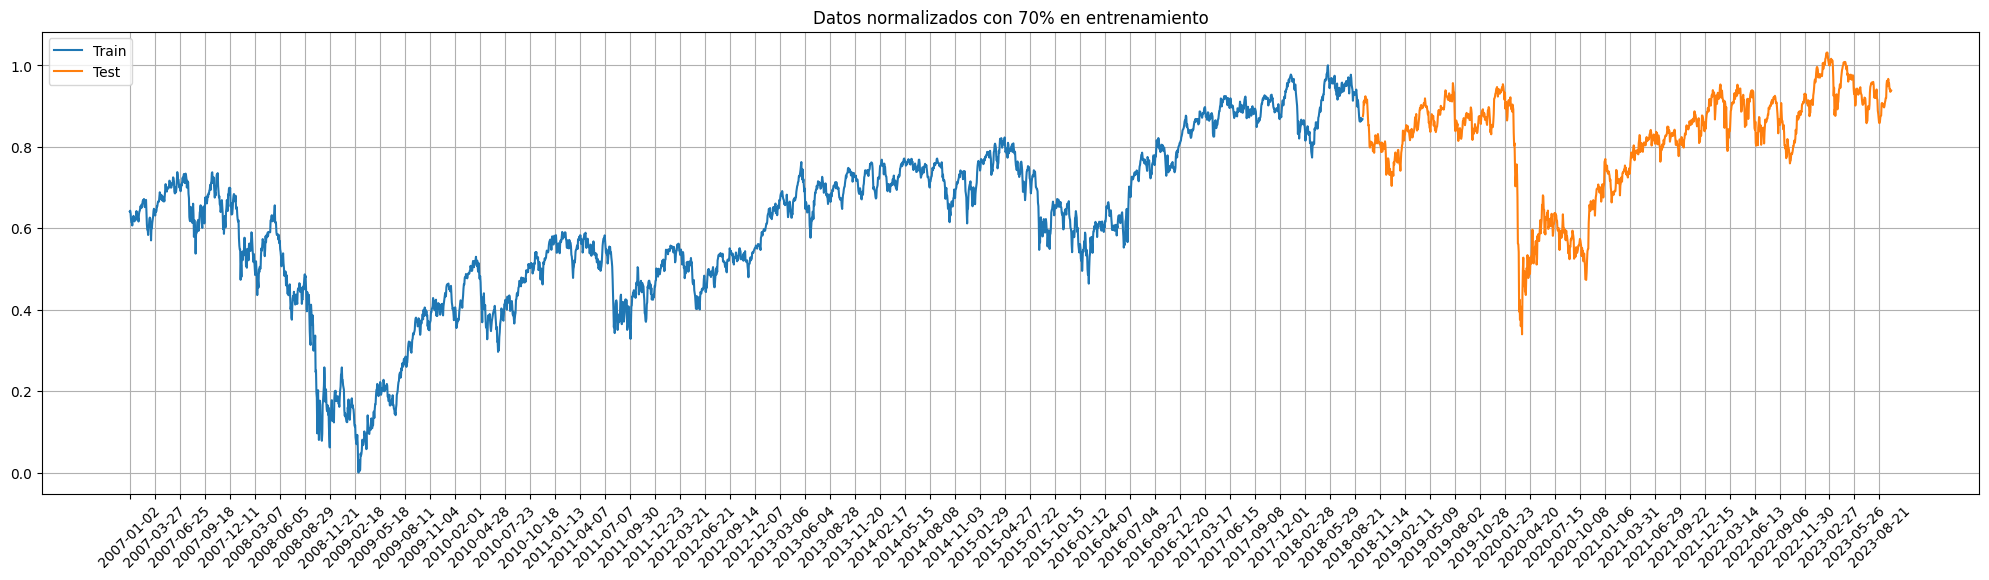

In [ ]:
plt.figure(figsize=(25,6))
plt.title("Datos normalizados con 70% en entrenamiento")
plt.plot(pd.Series(train_data_7,index = indices[0:len(train_data7)]), label = "Train")
plt.plot(pd.Series(test_data_7,index = indices[len(train_data7):]), label = "Test")
plt.xticks(datosf.index[::60], rotation=45)
plt.grid()
plt.legend()

Function to split the univariate sequence into sequences of n_steps elements.
Toma una secuencia de datos (sequence) y la divide en subsecuencias de tamaño n_steps, devuelve un array con las subsecuencias (X) y otro con los siguientes datos de cada subsecuencia en la secuencia original (y).

In [ ]:
# split a univariate sequence
def split_sequence(sequence: np.ndarray, n_steps: int) -> tp.Tuple[np.ndarray, np.ndarray]:
    """
    Divide un array de datos en subsecuencias de tamaño n_steps.
    Devuelve un array con las subsecuencias y otro con los  datos siguientes de cada subsecuencia en la original.
    """
    X, y = list(), list() #define listas vacías
    for i in range(len(sequence) - n_steps):
         # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        #el ciclo for se rompe cuando el índice final de la i-ésima
        #subsecuencia es igual o más grande que el índice final de la sec. original
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return(array(X), array(y))

In [ ]:
n_steps = 5
# split into samples
X8, y8 = split_sequence(np.array(train_data_8).astype(np.float32), n_steps) #obtiene subsecuencias de los datos de entrenamiento para p=0.8
X7, y7 = split_sequence(np.array(train_data_7).astype(np.float32), n_steps) #obtiene subsecuencias de los datos de entrenamiento para p=0.7

In [ ]:
#Esta celda muestra como se ven los datos divididos en secuencias
#for i in range(len(X8)):
    #print(X8[i], y8[i])

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
#We are working with a univariate series, so the number of features is one,
#for one variable.
X8 = X8.reshape((X8.shape[0], X8.shape[1], n_features))
X7 = X7.reshape((X7.shape[0], X7.shape[1], n_features))

# DEFINIMOS EL MODELO


En la siguiente celda se define el modelo. La función de activación será relu, dada por:
$$relu(x) = máx\{0,x\}$$
es decir:
relu(x) = \begin{cases}
      0 & \text{si } x < 0, \\
      x & \text{si } x \geq 0.
   \end{cases}
La función de pérdida es mean squared error, dada por:
 $$
MSE = \frac{1}{n}\sum_{i=0}^{n}(y_i - \hat{y_i})^2
 $$
 Donde $y_i$ es el valor objetivo y $\hat{y_i}$ es el valor predicho por el modelo

In [ ]:
model = Sequential()
  #el modelo secuencial es util para una pila de capas simples, donde cada una tiene
#solo un tensor de entrada y uno de salida
  #Hidden layer 1
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  #Hidden layer 2
model.add(Dropout(0.2))
  #Hidden layer 3
model.add(LSTM(64, activation='relu'))
  #Hidden layer 4
model.add(Dropout(0.1))
  #Hidden layer 5
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
  #Output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=0.0001, mode='min', restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# PREDICCIONES PARA 80% DE LOS DATOS COMO ENTRENAMIENTO

In [ ]:
! pip install --force-reinstall tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 749.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319

In [ ]:
model.fit(X8, y8, epochs= 90, batch_size = 64 ,verbose=1, callbacks=early_stopping)

Epoch 1/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6614e-04
Epoch 2/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3361e-04
Epoch 3/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7225e-04
Epoch 4/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9509e-04
Epoch 5/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6178e-04
Epoch 6/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5212e-04
Epoch 7/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3772e-04
Epoch 8/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1666e-04
Epoch 9/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2347e-04
Epoch 10/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8443e-04
Epoch 11/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1566e-04


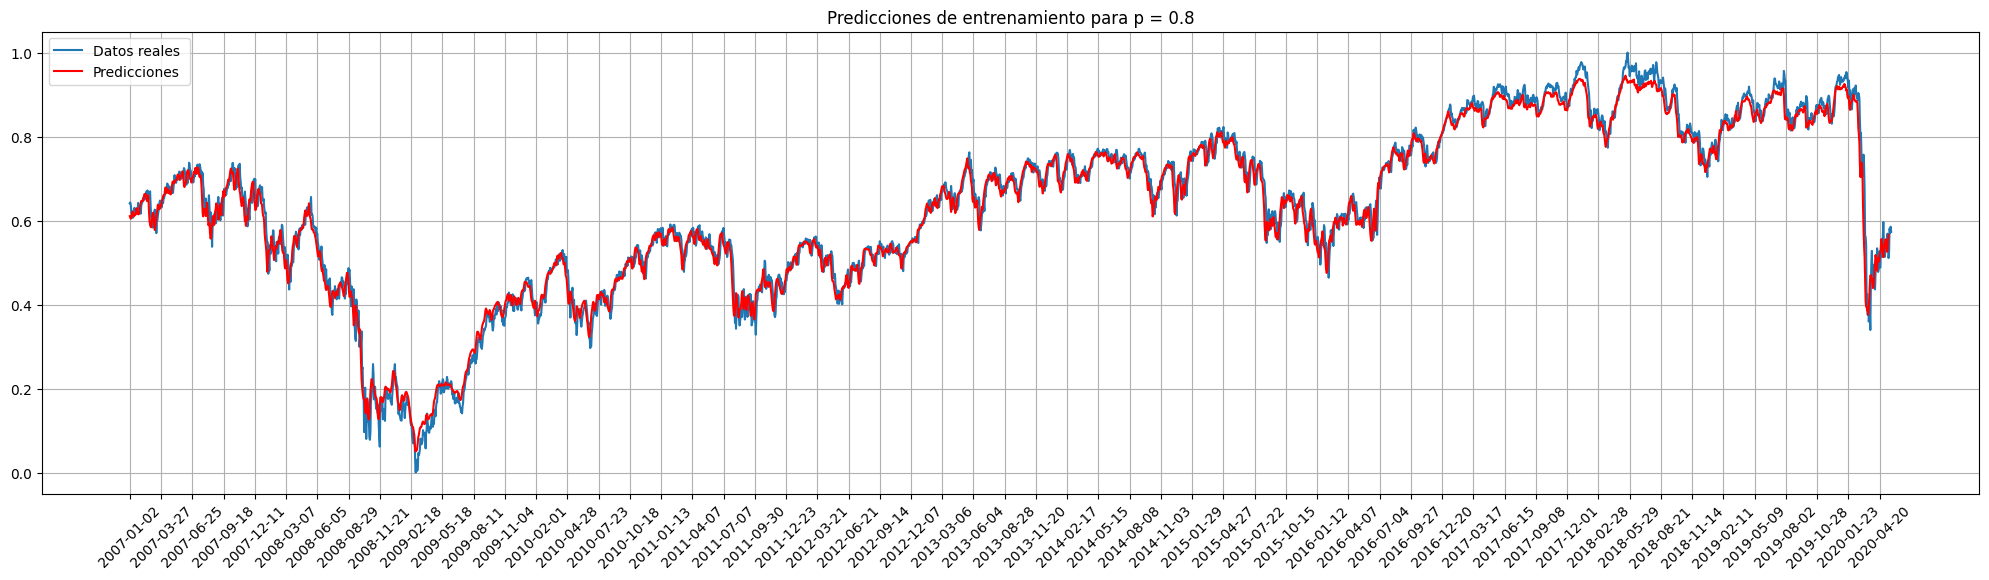

In [ ]:
training_predictions = model.predict(X8, verbose=0).flatten()
plt.figure(figsize=(25,6))
plt.title("Predicciones de entrenamiento para p = 0.8")
plt.plot(serie_train_8)
plt.plot(pd.Series(training_predictions), color = "red")
plt.xticks(serie_train_8.index[::60], rotation=45)
plt.grid()
plt.legend(['Datos reales ', 'Predicciones'])


## Hacemos zoom para apreciar mejor el comportamiento

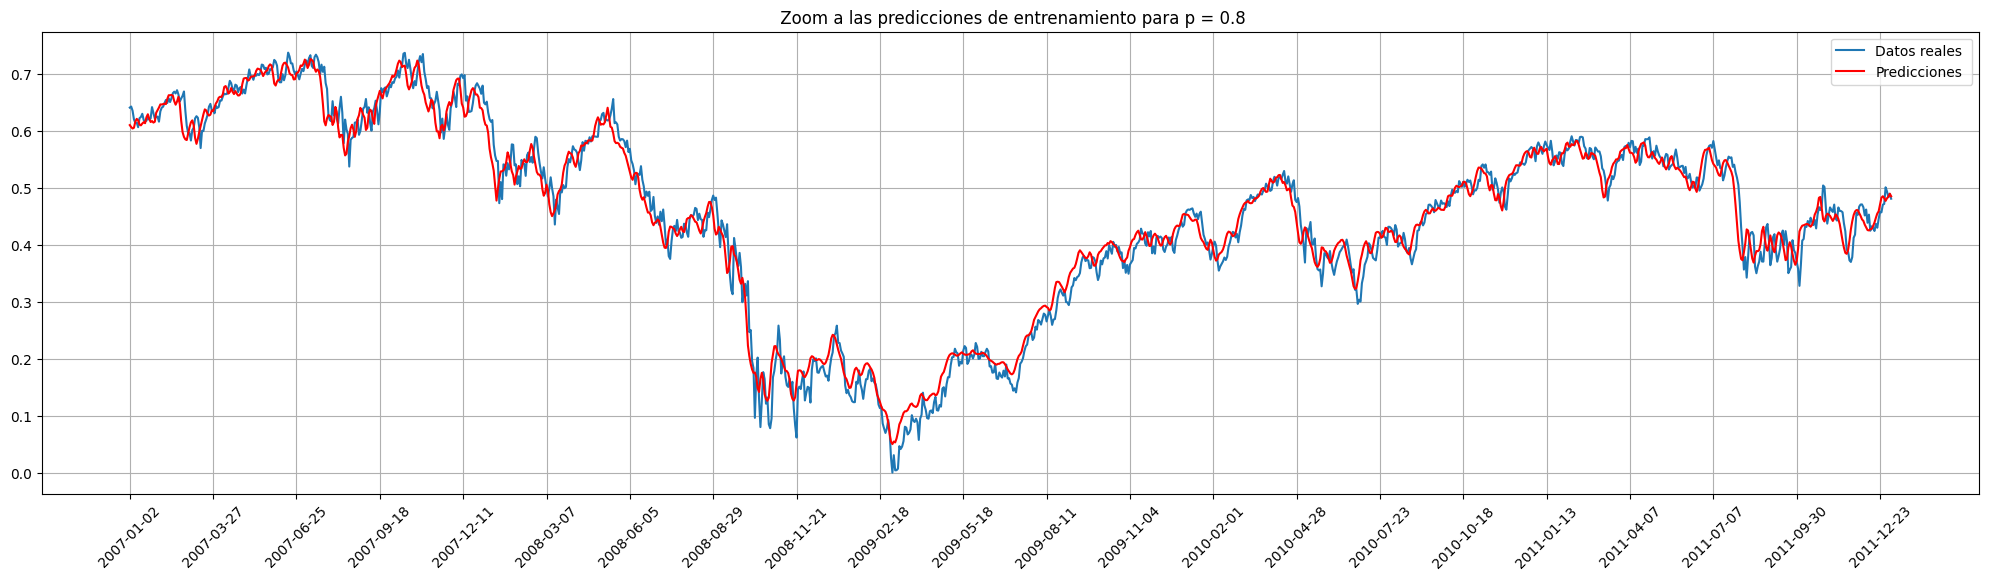

In [ ]:
plt.figure(figsize=(25,6))
plt.title(" Zoom a las predicciones de entrenamiento para p = 0.8")
plt.plot(serie_train_8[:1269])
plt.plot(pd.Series(training_predictions)[:1269], color = "red")
plt.xticks(serie_train_8[:1269].index[::60], rotation=45)
plt.grid()
plt.legend(['Datos reales ', 'Predicciones'])

In [ ]:
#esta celda hace predicciones supervisadas
equis8, p8 = split_sequence(np.array(test_data_8).astype(np.float32), n_steps)#aplica la función split a los datos de prueba
equis8 = equis8.reshape(equis8.shape[0], equis8.shape[1], n_features)#Le damos la forma que necesita el modelo
P8 = model.predict(equis8, verbose = 0)#Usamos .predict sobre el array que acabamos de hacer

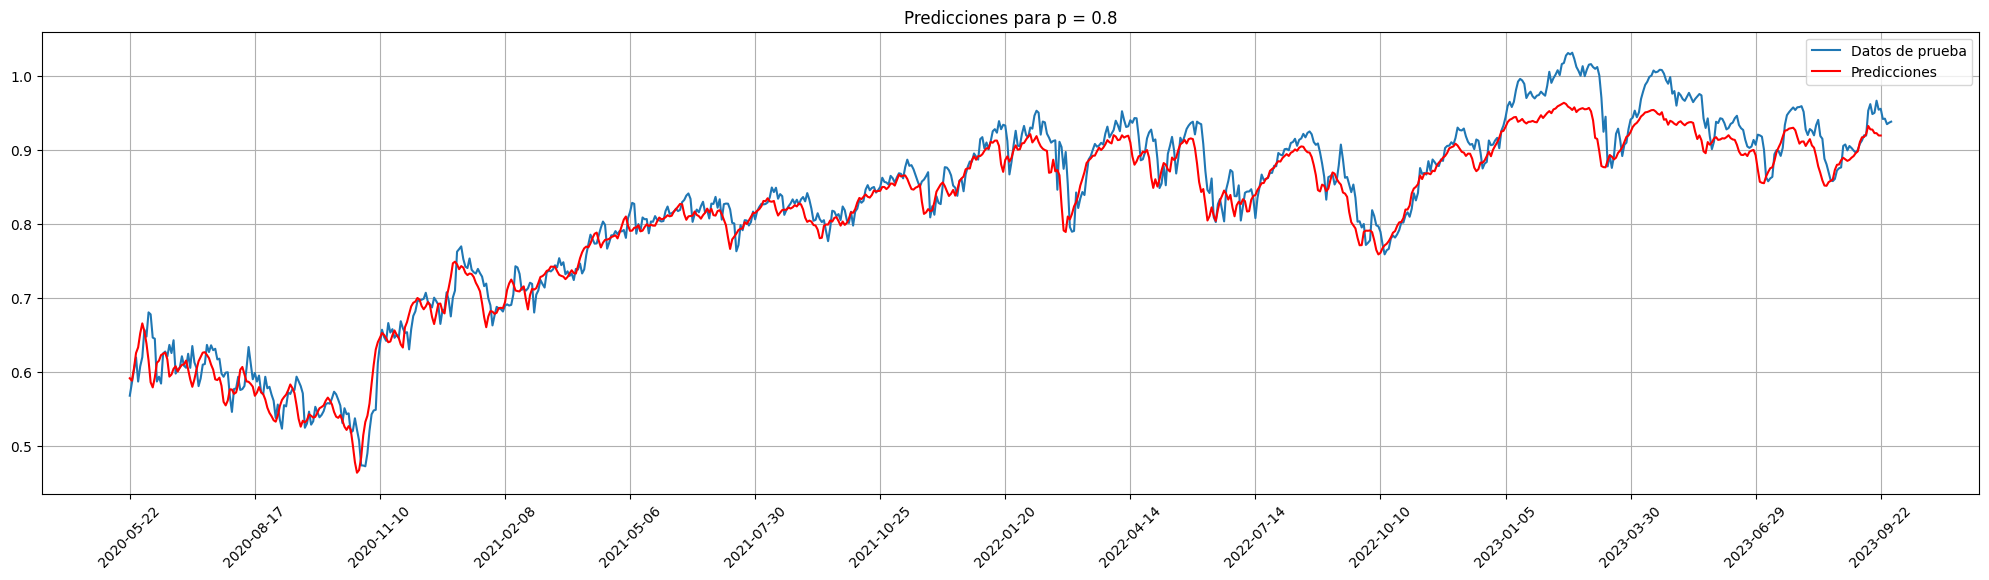

In [ ]:
#Graficamos las predicciones y los datos reales
plt.figure(figsize=(25,6))
plt.title("Predicciones para p = 0.8")
plt.plot(serie_test_8)
plt.plot(pd.Series(P8.flatten()),color = "red")
plt.xticks(serie_test_8.index[::60], rotation=45)
plt.grid()
plt.legend(['Datos de prueba', 'Predicciones'])
plt.show()


In [ ]:
#Caluculamos MSE para entrenemiento y prueba
training_mse = mean_squared_error(serie_train_8[:-5], training_predictions)
test_mse = mean_squared_error(P8.flatten(), serie_test_8[0:-5])
print("MSE de entrenamiento:", training_mse)
print("MSE de prueba:", test_mse)

MSE de entrenamiento: 0.0006621492205266095
MSE de prueba: 0.0007863512746961893


# PREDICCIONES PARA 70% DE LOS DATOS COMO ENTRENAMIENTO

In [ ]:
model.fit(X7, y7, epochs= 90, batch_size = 64 ,verbose=0, callbacks=early_stopping)

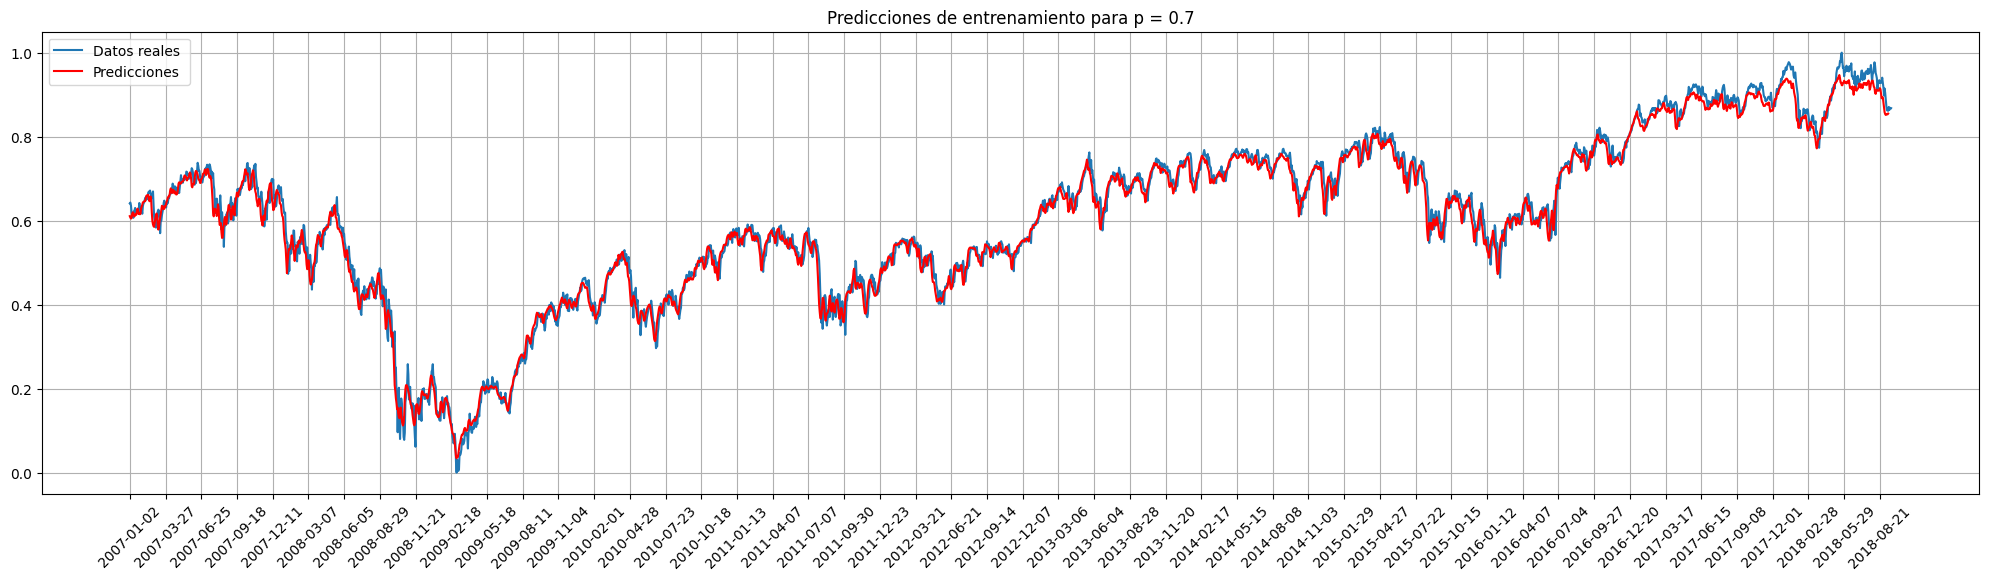

In [ ]:
training_predictions_7 = model.predict(X7, verbose=0).flatten()
plt.figure(figsize=(25,6))
plt.title("Predicciones de entrenamiento para p = 0.7")
plt.plot(serie_train_7)
plt.plot(pd.Series(training_predictions_7), color = "red")
plt.xticks(serie_train_7.index[::60], rotation=45)
plt.grid()
plt.legend(['Datos reales ', 'Predicciones'])

## Hacemos zoom para apreciar mejor

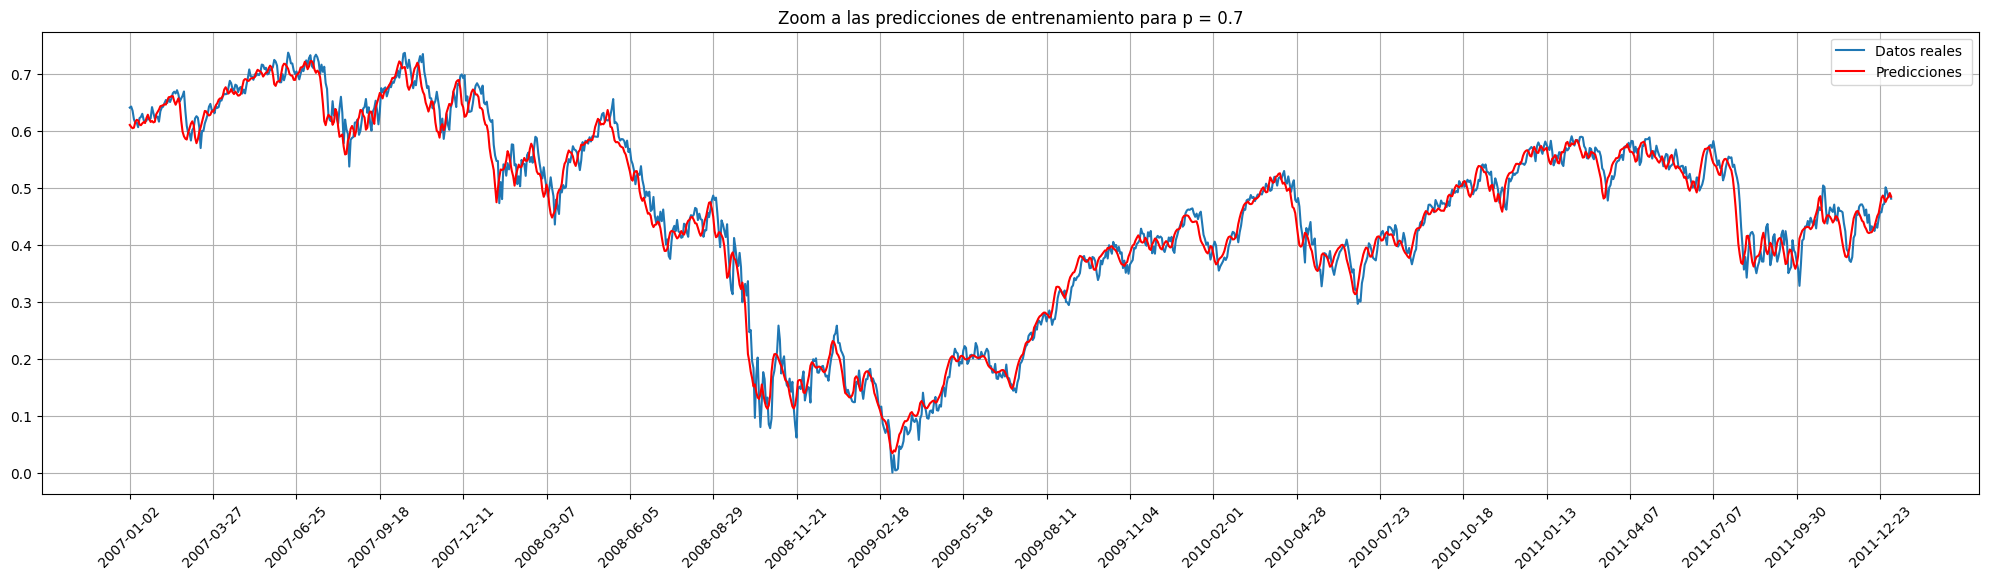

In [ ]:
plt.figure(figsize=(25,6))
plt.title("Zoom a las predicciones de entrenamiento para p = 0.7")
plt.plot(serie_train_7[:1269])
plt.plot(pd.Series(training_predictions_7[:1269]), color = "red")
plt.xticks(serie_train_7[:1269].index[::60], rotation=45)
plt.grid()
plt.legend(['Datos reales ', 'Predicciones'])

In [ ]:
#Predicciones supervisadas
equis7, p7 = split_sequence(np.array(test_data_7).astype(np.float32), n_steps)#aplica la función split a los datos de prueba
equis7 = equis7.reshape(equis7.shape[0], equis7.shape[1], n_features)#Le damos la forma que necesita el modelo
P7 = model.predict(equis7, verbose = 0)#Usamos .predict sobre el array que acabamos de hacer

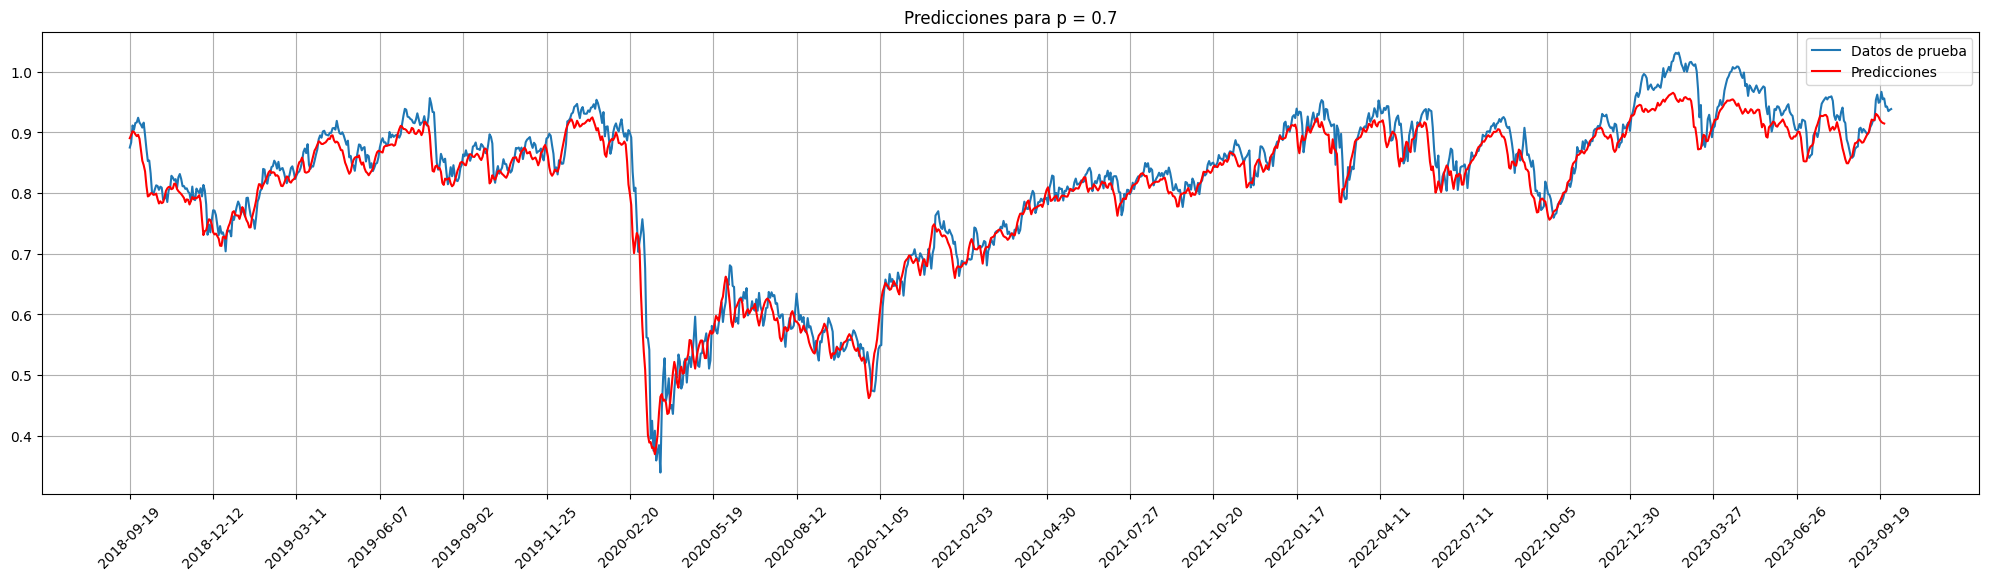

In [ ]:
#Graficamos las predicciones y los datos reales
plt.figure(figsize=(25,6))
plt.title("Predicciones para p = 0.7")
plt.plot(serie_test_7)
plt.plot(pd.Series(P7.flatten()),color = "red")
plt.xticks(serie_test_7.index[::60], rotation=45)
plt.grid()
plt.legend(['Datos de prueba', 'Predicciones'])
plt.show()

In [ ]:
training_mse_7 = mean_squared_error(serie_train_7[:-5], training_predictions_7)
test_mse_7 = mean_squared_error(P7.flatten(), serie_test_7[0:-5])
print("MSE de entrenamiento:", training_mse_7)
print("MSE de prueba:", test_mse_7)

MSE de entrenamiento: 0.0005726293945148316
MSE de prueba: 0.0009932644771929997
